# Import requirements

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

#new model
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,

    AutoModelForSequenceClassification,
    AutoTokenizer
)

# 1. Preprocess

In [4]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.train.1 to sentiment.train.1
Saving test_no_label.csv to test_no_label.csv


In [7]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [8]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [9]:
train_pos[:10]

['101 6581 2833 1012 102',
 '101 21688 8013 2326 1012 102',
 '101 2027 2036 2031 3679 19247 1998 3256 6949 2029 2003 2428 2204 1012 102',
 '101 2009 1005 1055 1037 2204 15174 2098 7570 22974 2063 1012 102',
 '101 1996 3095 2003 5379 1012 102',
 '101 2204 3347 2833 1012 102',
 '101 2204 2326 1012 102',
 '101 11350 1997 2154 2003 25628 1998 7167 1997 19247 1012 102',
 '101 2307 2173 2005 6265 2030 3347 27962 1998 5404 1012 102',
 '101 1996 2047 2846 3504 6429 1012 102']

In [10]:
train_neg[:10]

['101 1045 2001 13718 13534 1012 102',
 '101 2061 2006 2000 1996 7570 22974 2229 1010 1996 3059 2003 2236 2448 1997 1996 4971 1012 102',
 '101 10124 6240 1998 1037 10228 1997 29022 2292 8525 3401 1012 102',
 '101 2498 2428 2569 1004 2025 11007 1997 1996 1002 1035 16371 2213 1035 3976 6415 1012 102',
 '101 2117 1010 1996 21475 7570 22974 2063 1010 2009 2003 2012 3217 18436 1012 102',
 '101 1045 2018 2000 3477 1002 1035 16371 2213 1035 2000 5587 8808 2000 1996 7570 22974 2063 1012 102',
 '101 2016 2409 2033 2045 2001 1037 3715 2005 1996 11225 2006 1996 2217 1012 102',
 '101 2024 2017 12489 2033 1029 102',
 '101 1045 2001 2025 2183 2000 3477 2005 1996 11225 2006 1996 2217 1012 102',
 '101 1045 3641 2009 2302 2292 8525 3401 1010 20856 1010 24444 1010 2030 11225 1012 102']

In [11]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [12]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [13]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([ 101, 6581, 2833, 1012,  102]), array([1]))
(array([  101, 21688,  8013,  2326,  1012,   102]), array([1]))
(array([  101,  2027,  2036,  2031,  3679, 19247,  1998,  3256,  6949,
        2029,  2003,  2428,  2204,  1012,   102]), array([1]))
(array([  101,  2009,  1005,  1055,  1037,  2204, 15174,  2098,  7570,
       22974,  2063,  1012,   102]), array([1]))
(array([ 101, 1996, 3095, 2003, 5379, 1012,  102]), array([1]))
(array([ 101, 2204, 3347, 2833, 1012,  102]), array([1]))
(array([ 101, 2204, 2326, 1012,  102]), array([1]))
(array([  101, 11350,  1997,  2154,  2003, 25628,  1998,  7167,  1997,
       19247,  1012,   102]), array([1]))
(array([  101,  2307,  2173,  2005,  6265,  2030,  3347, 27962,  1998,
        5404,  1012,   102]), array([1]))
(array([ 101, 1996, 2047, 2846, 3504, 6429, 1012,  102]), array([1]))
(array([ 101, 2023, 2173, 2001, 2200, 2204, 1012,  102]), array([1]))


In [14]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)

    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [15]:
train_batch_size=128 #batch size -> 32 to 128
eval_batch_size=128 #batch size -> 64 to 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=True, collate_fn=collate_fn_style, #shuffle false -> true
                                         num_workers=2)

In [16]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [19]:
import matplotlib.pyplot as plt
import time
iter_x = []
max_iteration = 0
acc_y = []
loss_y = []

starttime = time.time()

In [20]:

train_epoch = 3
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            # output = model(input_ids=input_ids,
            #                attention_mask=attention_mask,
            #                token_type_ids=token_type_ids,
            #                position_ids=position_ids,
            #                labels=labels)
            output = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        position_ids=position_ids,
                        labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

            #### matplotlib ###
            if max_iteration < iteration:
                max_iteration = iteration
                if epoch>0:
                    assert False
            ### matplotlib ###

            if iteration != 0 and iteration % int(len(train_loader) / 20) == 0:

                
            
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        # output = model(input_ids=input_ids,
                        #                attention_mask=attention_mask,
                        #                token_type_ids=token_type_ids,
                        #                position_ids=position_ids,
                        #                labels=labels)
                        output = model(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids,
                                        position_ids=position_ids,
                                        labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)


                ### matplotlib start ###
                
                iter_x.append(iteration)
                acc_y.append(acc)
                loss_y.append(valid_loss)
                
                ### matplotlib end ###



                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    torch.save(model.state_dict(), "./pytorch_model.bin")
                    lowest_valid_loss = valid_loss

Eval:  97%|█████████▋| 31/32 [00:04<00:00,  6.34it/s]
                                                     

Acc for model which have lower valid loss:  0.965


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]
                                                     

Acc for model which have lower valid loss:  0.9715


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  6.28it/s]
                                                     

Acc for model which have lower valid loss:  0.96925


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.92it/s]
                                                     

Acc for model which have lower valid loss:  0.97575


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.74it/s]
                                                     

Acc for model which have lower valid loss:  0.97725


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.42it/s]
                                                     

Acc for model which have lower valid loss:  0.978


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]
                                                     

Acc for model which have lower valid loss:  0.97475


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.39it/s]
                                                     

Acc for model which have lower valid loss:  0.97925


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.90it/s]
                                                     

Acc for model which have lower valid loss:  0.9805


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.97it/s]
                                                     

Acc for model which have lower valid loss:  0.978


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.68it/s]
                                                     

Acc for model which have lower valid loss:  0.98125


Epoch 2: 100%|██████████| 3463/3463 [30:48<00:00,  1.87batch/s, loss=0.05]


In [21]:
endtime = time.time()

In [22]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [23]:
test_dataset = test_df['Id']

In [24]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [25]:
test = make_id_file_test(tokenizer, test_dataset)

In [26]:
test[:10]

['101 2009 1005 1055 1037 2878 2047 3325 1998 2047 26389 2169 2051 2017 2175 1012 102',
 '101 2061 15640 2013 2019 2214 5440 1012 102',
 '101 2009 2003 1996 2087 14469 7273 1999 1996 3028 1012 102',
 '101 2079 2025 3696 1037 10084 2007 2122 2111 1012 102',
 '101 1045 2001 6091 1998 2016 2081 2033 2514 2061 6625 1998 6160 1012 102',
 '101 1996 2069 2518 2057 2363 2008 2001 2980 2001 1996 4157 1012 102',
 '101 2053 1010 2025 1996 3924 2012 2004 2226 1010 1996 3924 1999 3502 2152 1012 102',
 '101 2027 3288 2009 2041 2392 2005 2017 1998 2024 2200 14044 1012 102',
 '101 4606 1996 12043 2106 1050 1005 1056 2130 2113 2129 2000 2147 1996 3274 1012 102',
 '101 2027 2031 2019 6581 4989 1997 25025 2015 2000 5454 2013 1012 102']

In [27]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [28]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [29]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1] #bug
    sorted_indices = [i for i in range(len(input_ids))]
    
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [30]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [40]:
with torch.no_grad():
    model.eval()
    predictions = []
    ex0 = []
    ex1 = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        # output = model(input_ids=input_ids,
        #                attention_mask=attention_mask,
        #                token_type_ids=token_type_ids,
        #                position_ids=position_ids)
        output = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      token_type_ids=token_type_ids,
                      position_ids=position_ids)

        logits = output.logits
        print(logits)
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        ex0 += [example[0].cpu().numpy() for example in logits]
        ex1 += [example[1].cpu().numpy() for example in logits]
        predictions += batch_predictions


Test:   9%|▉         | 3/32 [00:00<00:02, 12.18it/s]

tensor([[-3.3827,  4.3765],
        [ 4.6261, -4.7531],
        [-3.4303,  4.4030],
        [ 4.6243, -4.7875],
        [-2.8917,  3.9537],
        [ 4.1636, -3.9467],
        [ 4.1715, -3.8630],
        [-2.6892,  3.8036],
        [ 4.6132, -4.7001],
        [-3.4466,  4.3734],
        [-3.3414,  4.4092],
        [ 4.5983, -4.8498],
        [ 4.5123, -4.5595],
        [-3.0913,  4.1458],
        [-3.4463,  4.4489],
        [ 4.6011, -4.8298],
        [-1.0686,  1.8876],
        [-2.9072,  3.9862],
        [ 4.5808, -4.7354],
        [ 4.5838, -4.7899],
        [ 4.5841, -4.7346],
        [-2.9521,  3.9476],
        [ 3.8802, -3.5570],
        [-3.3032,  4.3117],
        [ 4.5499, -4.7354],
        [ 4.5387, -4.5453],
        [-2.9987,  4.0196],
        [-2.9094,  4.0227],
        [-0.5131,  1.4146],
        [ 4.6188, -4.8107],
        [ 4.6509, -4.7983],
        [ 4.6017, -4.7003]], device='cuda:0')
tensor([[ 4.6255, -4.7933],
        [ 4.5990, -4.8216],
        [ 4.5928, -4.6179],
  


Test:  25%|██▌       | 8/32 [00:00<00:01, 18.09it/s]

tensor([[ 4.2809, -4.0619],
        [ 4.5550, -4.5184],
        [ 4.6033, -4.7805],
        [-3.4397,  4.4275],
        [-3.6661,  4.5985],
        [-2.9351,  3.9777],
        [ 4.6621, -4.7073],
        [ 4.6254, -4.8171],
        [ 4.6647, -4.7330],
        [-2.5007,  3.5922],
        [ 4.6014, -4.7369],
        [ 4.5418, -4.5943],
        [-3.3175,  4.3414],
        [ 4.6441, -4.8017],
        [-1.3971,  2.3154],
        [-2.8993,  3.9447],
        [ 4.5789, -4.6426],
        [ 4.5156, -4.6394],
        [ 4.4454, -4.3795],
        [ 4.6333, -4.7673],
        [ 4.6009, -4.7229],
        [-2.4871,  3.5069],
        [-2.6640,  3.7218],
        [ 4.3947, -4.2712],
        [ 4.5950, -4.7438],
        [ 4.6007, -4.8195],
        [-3.0879,  4.0673],
        [ 4.6090, -4.7886],
        [-2.9621,  4.0237],
        [-3.5055,  4.4736],
        [ 4.6301, -4.8175],
        [-1.8550,  2.8611]], device='cuda:0')
tensor([[-3.7143,  4.6073],
        [ 4.6647, -4.7398],
        [-3.2255,  4.2350],
  


Test:  44%|████▍     | 14/32 [00:00<00:00, 22.36it/s]

tensor([[-3.1257,  4.1329],
        [ 2.4778, -1.7555],
        [-3.0954,  4.1143],
        [-2.9767,  4.0729],
        [-2.8649,  3.8918],
        [ 4.6137, -4.6470],
        [-2.9987,  4.0494],
        [ 4.5878, -4.6702],
        [-3.5099,  4.4924],
        [-0.6696,  1.5321],
        [-2.4102,  3.4749],
        [ 4.4718, -4.3684],
        [ 3.1592, -2.5973],
        [ 4.1349, -3.9156],
        [-3.3873,  4.4149],
        [ 4.6140, -4.6662],
        [ 4.5919, -4.6458],
        [-2.9658,  3.9913],
        [ 3.8419, -3.4557],
        [-2.8902,  3.9439],
        [-1.5768,  2.5031],
        [ 3.7891, -3.2998],
        [ 4.4410, -4.3192],
        [ 4.4348, -4.3331],
        [ 4.5894, -4.8091],
        [ 4.6177, -4.6986],
        [-3.2705,  4.2790],
        [ 4.6375, -4.7694],
        [ 4.5903, -4.6539],
        [ 4.4522, -4.3411],
        [ 4.3676, -4.2683],
        [-3.5028,  4.4481]], device='cuda:0')
tensor([[ 4.3544, -4.1591],
        [-3.7451,  4.5701],
        [-3.6044,  4.5389],
  


Test:  62%|██████▎   | 20/32 [00:00<00:00, 24.91it/s]

tensor([[-3.2179,  4.2675],
        [-3.5341,  4.4888],
        [-3.6398,  4.5436],
        [-3.2667,  4.2368],
        [-2.9198,  3.9202],
        [-2.4508,  3.6046],
        [-3.3484,  4.3297],
        [-3.2905,  4.2494],
        [ 4.6332, -4.6678],
        [-1.4621,  2.3946],
        [ 4.6312, -4.7710],
        [ 4.6164, -4.6963],
        [-2.1513,  3.0326],
        [-3.5438,  4.5081],
        [-2.9315,  3.9244],
        [ 4.6344, -4.7891],
        [-3.2946,  4.2684],
        [ 4.6292, -4.7588],
        [ 4.5473, -4.7780],
        [-2.4548,  3.4975],
        [ 4.6368, -4.7999],
        [ 4.5885, -4.6017],
        [ 4.5916, -4.6287],
        [-0.5048,  1.4102],
        [ 1.2343, -0.4512],
        [ 4.5844, -4.7833],
        [ 4.6537, -4.6018],
        [ 3.6658, -3.1258],
        [ 3.3511, -2.6713],
        [ 4.2738, -4.0847],
        [ 4.4617, -4.2836],
        [-2.9472,  3.9437]], device='cuda:0')
tensor([[-3.7198,  4.5589],
        [ 4.6162, -4.8366],
        [ 4.4471, -4.2959],
  


Test:  81%|████████▏ | 26/32 [00:01<00:00, 25.92it/s]

tensor([[ 4.6225, -4.7885],
        [ 4.5799, -4.5471],
        [ 4.6341, -4.7904],
        [ 4.6429, -4.8238],
        [-3.6192,  4.5420],
        [ 4.6225, -4.7830],
        [ 4.6156, -4.7758],
        [ 4.5545, -4.7863],
        [ 4.6145, -4.8072],
        [-3.5125,  4.4162],
        [ 4.6149, -4.8233],
        [-3.4833,  4.5064],
        [ 4.6300, -4.8073],
        [ 4.5808, -4.8038],
        [-3.5782,  4.5257],
        [ 1.4367, -0.7239],
        [-2.7062,  3.7453],
        [ 4.3468, -4.2218],
        [-3.4162,  4.3980],
        [ 4.6007, -4.8264],
        [ 4.6100, -4.8168],
        [ 4.4665, -4.3845],
        [-2.6499,  3.7033],
        [ 4.5612, -4.8104],
        [ 4.5487, -4.8037],
        [ 4.5258, -4.5553],
        [-2.0647,  3.0666],
        [ 4.6126, -4.8082],
        [-3.4300,  4.4672],
        [ 4.6013, -4.8175],
        [ 4.6135, -4.7556],
        [-1.8462,  2.8726]], device='cuda:0')
tensor([[ 4.5923, -4.7350],
        [-0.5158,  1.3020],
        [ 4.1066, -3.7689],
  


Test:  91%|█████████ | 29/32 [00:01<00:00, 25.74it/s]
                                                     

tensor([[ 4.5748, -4.7860],
        [-3.1900,  4.2122],
        [-3.4415,  4.3928],
        [-3.6763,  4.6149],
        [-3.3946,  4.3254],
        [-3.4325,  4.3919],
        [-2.8504,  3.8952],
        [ 4.6262, -4.8267],
        [-3.4697,  4.4298],
        [ 4.6101, -4.7735],
        [-3.3930,  4.3881],
        [-2.6838,  3.7132],
        [-3.4002,  4.4049],
        [-2.4159,  3.5384],
        [ 4.5486, -4.7638],
        [ 4.2476, -4.1966],
        [-3.5632,  4.5096],
        [ 4.5923, -4.7625],
        [-1.3898,  2.2945],
        [ 4.5877, -4.8230],
        [ 4.6194, -4.7452],
        [-2.5931,  3.7433],
        [ 4.4188, -4.4529],
        [ 4.6160, -4.7747],
        [-2.5200,  3.5273],
        [-3.4926,  4.4717],
        [ 4.5404, -4.6191],
        [ 2.5638, -1.8725],
        [ 4.1144, -3.8713],
        [ 4.6098, -4.7527],
        [-3.5731,  4.5328],
        [-0.8303,  1.8177]], device='cuda:0')
tensor([[-3.3668,  4.3444],
        [ 4.2759, -4.0678],
        [-1.4122,  2.3309],
  

In [32]:
print(iter_x)
print(len(train_loader))

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460]
3463


In [33]:
test_df['Category'] = predictions

In [34]:
test_df.to_csv('submission_bert_base_uncased_matplotlib.csv', index=False)

In [41]:
test_df['ex0'] = ex0
test_df['ex1'] = ex1
test_df.to_csv('bert_base_uncased_softvoting.csv', index=False)

In [35]:
print(lowest_valid_loss)

0.05236840431462042


In [36]:
print(iter_x)
print(acc_y)
print(loss_y)
print(max_iteration)
iter_x_save = iter_x

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460]
[0.965, 0.9715, 0.96925, 0.97225, 0.97575, 0.97725, 0.97275, 0.9735, 0.978, 0.975, 0.97525, 0.97675, 0.97475, 0.97725, 0.97925, 0.9805, 0.98, 0.98125, 0.98025, 0.98025, 0.9795, 0.97875, 0.97875, 0.98025, 0.97825, 0.9795, 0.98075, 0.98025, 0.978, 0.98125, 0.97975, 0.9795, 0.9775, 0.9815, 0.98175, 0.9805, 0.97875, 0.97775, 0.98, 0.98, 0.98025, 0.9805, 0.9775, 0.9795, 0.9785, 0.97625, 0.98225, 0.9815, 0.97825, 0.977, 0.98125, 0.982, 0.9805, 0.97875, 0.9815, 0.98175, 0.9815, 0.9805, 0.98025, 0.983]
[0.10513500298839062, 0.08392773615196347, 0.07608683389844373, 0.07693805021699518, 0.06716240890091285, 0.06282730371458456, 0.07244417461333796, 0.0663

In [37]:
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
print(iter_x)

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 3635, 3808, 3981, 4154, 4327, 4500, 4673, 4846, 5019, 5192, 5365, 5538, 5711, 5884, 6057, 6230, 6403, 6576, 6749, 6922, 7097, 7270, 7443, 7616, 7789, 7962, 8135, 8308, 8481, 8654, 8827, 9000, 9173, 9346, 9519, 9692, 9865, 10038, 10211, 10384]


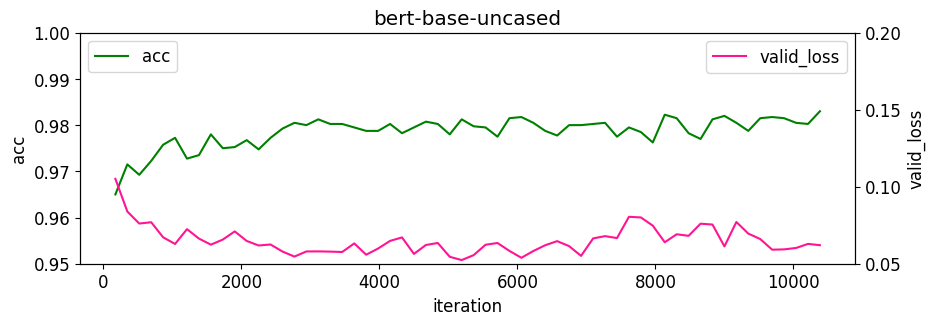

In [43]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['font.size'] = 12

x = iter_x
y1 = acc_y
y2 = loss_y

fig, ax1 = plt.subplots()
ax1.set_xlabel('iteration')
ax1.set_ylabel('acc')
ax1.plot(x, y1, color='green',label='acc')
ax1.legend(loc='upper left')
ax1.set_ylim([0.950,1])

ax2 = ax1.twinx()
ax2.set_ylabel('valid_loss')
ax2.plot(x, y2, color='deeppink',label='valid_loss')
ax2.legend(loc='upper right')
ax2.set_ylim([0.05,0.2])

plt.title("bert-base-uncased")

plt.show()

In [39]:
print(endtime - starttime)

5540.933182001114
